In [1]:
from paretoGraphRestaurants import *

import pickle
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
# function to sample numItems from the dataset
def sample_dataset(simMatrix, graphMat, item_ids, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        graphMat (np.ndarray): Graph distance matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_graphMat (np.ndarray): Sampled graph distance matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
    '''
    if numItems is None or numItems <= 0 or numItems >= len(item_ids):
        return simMatrix, graphMat, item_ids
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_graphMat = graphMat[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    return sampled_simMatrix, sampled_graphMat, sampled_item_ids

### Yelp - Average plotting across different random samples

In [3]:
def findApproximateParetoSolutionsRestaurantsGraph(simMatrix, graphMat, item_ids, sample_size, num_samples=10, maxDiameter=None, dataset_name=""):
    '''
    Run graph-diameter algorithms over multiple random samples, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        graphMat (np.ndarray): Graph distance matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        sample_size (int): Number of items to sample from the dataset.
        num_samples (int): Number of random samples to run.
        maxDiameter (float | None): Maximum diameter for plotting grid. If None, inferred from graphMat.
        dataset_name (str | None): Optional dataset name for output file naming.
    '''
    if maxDiameter is None:
        maxDiameter = float(np.max(graphMat)) if np.asarray(graphMat).size > 0 else 1.0

    # Diameter grid (same for all samples)
    num_steps, min_diameter = 15, 0.0
    diameter_arr = np.linspace(min_diameter, maxDiameter, num_steps)

    algo_names = ["ParetoGreedy-Diameter", "PlainGreedy", "TopK-degree", "PruneGraph"]

    def align_to_diameter_arr(diameters, objs):
        if len(diameters) == 0 or len(objs) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters = np.array(diameters, dtype=float)
        objs = np.array(objs, dtype=float)
        min_len = min(len(diameters), len(objs))
        diameters = diameters[:min_len]
        objs = objs[:min_len]
        agg = {}
        for d, o in zip(diameters, objs):
            if d in agg:
                agg[d] = max(agg[d], o)
            else:
                agg[d] = o
        if len(agg) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters_sorted = np.array(sorted(agg.keys()), dtype=float)
        objs_sorted = np.array([agg[d] for d in diameters_sorted], dtype=float)
        return np.interp(diameter_arr, diameters_sorted, objs_sorted, left=objs_sorted[0], right=objs_sorted[-1])

    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_diams_all = []
    pareto_points_counts = []

    for _ in range(num_samples):
        sampled_sim, sampled_graph, sampled_ids = sample_dataset(simMatrix, graphMat, item_ids, sample_size)
        dist_mat = sampled_graph

        sample_objectives = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}

        pareto = paretoGraphRestaurants(n_items=sampled_ids, simMatrix=sampled_sim, pairwise_costs=dist_mat)

        diameters, best_objs, _, _, runTime = pareto.ParetoGreedyDiameter()
        sample_objectives['ParetoGreedy-Diameter'] = list(align_to_diameter_arr(diameters, best_objs))
        sample_runtimes['ParetoGreedy-Diameter'].append(runTime)
        pareto_diams_all.extend(diameters)
        pareto_points_counts.append(len(diameters))

        pg_diam, pg_objs, _, _, pg_time = pareto.plainGreedyDistanceScaled()
        sample_objectives['PlainGreedy'] = list(align_to_diameter_arr(pg_diam, pg_objs))
        sample_runtimes['PlainGreedy'].append(pg_time)

        tk_diam, tk_objs, _, _, tk_time = pareto.topKDistanceScaled()
        sample_objectives['TopK-degree'] = list(align_to_diameter_arr(tk_diam, tk_objs))
        sample_runtimes['TopK-degree'].append(tk_time)

        pr_radii, pr_objs, _, _, pr_time = pareto.graphPruning()
        sample_objectives['PruneGraph'] = list(align_to_diameter_arr(pr_radii, pr_objs))
        sample_runtimes['PruneGraph'].append(pr_time)

        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(diameter_arr, dtype=float)
            all_objectives[alg].append(arr)
            runtimes = sample_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 0.5

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']
    color_map = {
        "PlainGreedy": colors[0],
        "PruneGraph": colors[2],
        "TopK-degree": colors[4],
        "ParetoGreedy-Diameter": colors[3],
    }
    marker_map = {
        "PlainGreedy": "o",
        "PruneGraph": "^",
        "TopK-degree": "D",
        "ParetoGreedy-Diameter": "D",
    }
    plot_order = ["PlainGreedy", "PruneGraph", "TopK-degree", "ParetoGreedy-Diameter"]
    legend_order = ["ParetoGreedy-Diameter", "PlainGreedy", "PruneGraph", "TopK-degree"]

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    rng = np.random.default_rng()
    for i, alg in enumerate(plot_order):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg == "ParetoGreedy-Diameter"
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = color_map.get(alg, colors[i])
        marker = marker_map.get(alg, markers[i % len(markers)])
        zorder = 4 if is_pareto else 3
        if is_pareto:
            marker = "D"

        label = rf"\\texttt{{{alg}}} (ours)" if is_pareto else rf"\\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(diameter_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_diams_unique = np.unique(np.array(pareto_diams_all, dtype=float))
            pareto_diams_unique = pareto_diams_unique[(pareto_diams_unique >= diameter_arr.min()) & (pareto_diams_unique <= diameter_arr.max())]
            if pareto_diams_unique.size > 0:
                keep_count = max(1, int(np.ceil(pareto_diams_unique.size * 0.5)))
                keep_idx = rng.choice(pareto_diams_unique.size, size=keep_count, replace=False)
                pareto_diams_unique = np.sort(pareto_diams_unique[keep_idx])
                min_sep = 0.5 * (diameter_arr[1] - diameter_arr[0]) if diameter_arr.size > 1 else 0
                filtered = [pareto_diams_unique[0]]
                for d in pareto_diams_unique[1:]:
                    if d - filtered[-1] >= min_sep:
                        filtered.append(d)
                pareto_diams_unique = np.array(filtered, dtype=float)
            pareto_mean_vals = np.interp(pareto_diams_unique, diameter_arr, mean)
            ax.scatter(pareto_diams_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            from matplotlib.lines import Line2D
            pareto_legend_handle = Line2D([0], [0],
                                          color=color,
                                          linestyle=line_style,
                                          marker=marker,
                                          markersize=marker_size,
                                          markeredgewidth=1.1,
                                          markeredgecolor='k',
                                          linewidth=1.8)
        else:
            ax.plot(diameter_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(diameter_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Diameter, $c_d$', fontsize=28)
    ax.set_ylabel(r'Objective, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handle_map = dict(zip(labels, handles))
        pareto_label = label_map.get("ParetoGreedy-Diameter")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        ordered_labels = []
        if pareto_label:
            ordered_labels.append(pareto_label)
        ordered_labels.extend([label_map[alg] for alg in legend_order if alg != "ParetoGreedy-Diameter"])
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "graph"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_graph.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    if handles:
        legend_out_path = plots_dir / "graph_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=2, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

    return None

### Yelp Phoenix Experiments

2026-02-01 12:47:14,159 |INFO: Imported Yelp ids, Num Items: 1849
2026-02-01 12:47:14,170 |INFO: Imported Yelp similarity matrix, Shape: (1849, 1849)
2026-02-01 12:47:14,222 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:400
2026-02-01 12:47:16,297 |INFO: ParetoGreedyDiameter finished: max_objective=400.000, runtime=2.075s, items=400
2026-02-01 12:47:19,203 |INFO: PlainGreedyDistanceScaled finished: max_objective=399.707, runtime=2.616s
2026-02-01 12:47:19,348 |INFO: TopKDistanceScaled finished: max_objective=400.000, runtime=0.139s
2026-02-01 12:47:21,630 |INFO: GraphPruning finished: max_objective=400.000, runtime=2.281s
2026-02-01 12:47:21,636 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:400
2026-02-01 12:47:23,812 |INFO: ParetoGreedyDiameter finished: max_objective=400.000, runtime=2.175s, items=400
2026-02-01 12:47:26,401 |INFO: PlainGreedyDistanceScaled finished: max_objective=399.643, runtime=2.326s
2026-02-01 12:47:26,539 |INFO:

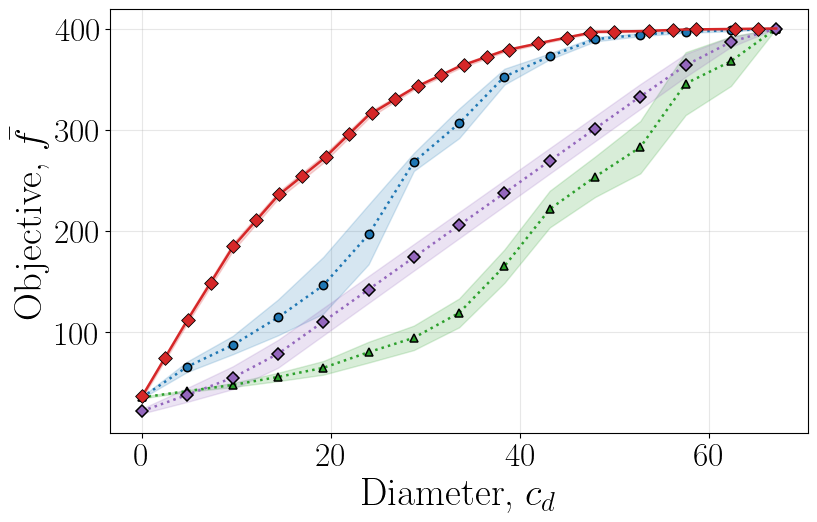

2026-02-01 12:48:27,251 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 2.074 ± 0.096
  - PlainGreedy: 2.398 ± 0.093
  - TopK-degree: 0.140 ± 0.013
  - PruneGraph: 2.245 ± 0.050


In [4]:
# Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
phoenix_ids, phoenix_simMatrix = import_yelp_data(data_path)
with open(data_path + 'graphMat.pkl', 'rb') as f:
    phoenix_graphMat = pickle.load(f)

# Adjust parameters as needed
sample_size = 400
num_samples = 10
findApproximateParetoSolutionsRestaurantsGraph(phoenix_simMatrix, phoenix_graphMat, phoenix_ids, sample_size, num_samples, dataset_name="Yelp_Phoenix")

### Yelp Vegas Experiments

2026-02-01 12:48:27,267 |INFO: Imported Yelp ids, Num Items: 3103
2026-02-01 12:48:27,292 |INFO: Imported Yelp similarity matrix, Shape: (3103, 3103)
2026-02-01 12:48:27,338 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:600
2026-02-01 12:48:33,341 |INFO: ParetoGreedyDiameter finished: max_objective=600.000, runtime=6.003s, items=600
2026-02-01 12:48:40,330 |INFO: PlainGreedyDistanceScaled finished: max_objective=599.433, runtime=6.220s
2026-02-01 12:48:40,762 |INFO: TopKDistanceScaled finished: max_objective=600.000, runtime=0.414s
2026-02-01 12:48:47,265 |INFO: GraphPruning finished: max_objective=600.000, runtime=6.502s
2026-02-01 12:48:47,275 |INFO: Initialized Pareto Restaurants - Graph Cost Instance, Num Items:600
2026-02-01 12:48:53,353 |INFO: ParetoGreedyDiameter finished: max_objective=600.000, runtime=6.077s, items=600
2026-02-01 12:49:00,900 |INFO: PlainGreedyDistanceScaled finished: max_objective=599.476, runtime=6.701s
2026-02-01 12:49:01,350 |INFO:

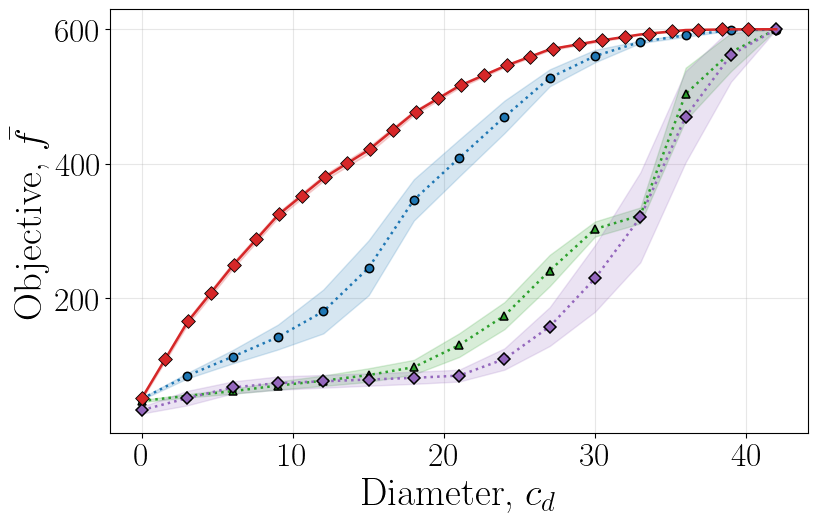

2026-02-01 12:51:48,839 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 5.782 ± 0.241
  - PlainGreedy: 6.420 ± 0.136
  - TopK-degree: 0.427 ± 0.011
  - PruneGraph: 6.640 ± 0.109


In [5]:
# Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
vegas_ids, vegas_simMatrix = import_yelp_data(data_path)
with open(data_path + 'graphMat.pkl', 'rb') as f:
    vegas_graphMat = pickle.load(f)

# Adjust parameters as needed
sample_size = 600
num_samples = 10
findApproximateParetoSolutionsRestaurantsGraph(vegas_simMatrix, vegas_graphMat, vegas_ids, sample_size, num_samples, dataset_name="Yelp_Vegas")